In [1]:
%reload_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp

import time as tt

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

import StreaMAX

## First, start by defining the parameters

In [2]:
# Flattened NFW halo
type_host   = 'NFW'
params_host = {'logM': 12.0, 'Rs': 25.0, 
                'a': 1.0, 'b': 1.0, 'c': 1.0,
                'dirx': 0.0, 'diry': 0.0, 'dirz': 1.0,
                'x_origin': 0.0, 'y_origin': 0.0, 'z_origin': 0.0}

# Plummer Sattelite
type_sat   = 'Plummer'
params_sat = {'logM': 8.0, 'Rs': 1.0,
                'x_origin': 100.0, 'y_origin': 0.0, 'z_origin': 0.0}

# Initial conditions
xv_f = jnp.array([100.0, 0.0, 0.0,  # Position in kpc
                0.0, 200.0, 0.0])   # Velocity in kpc/Gyr

# Integration time
time  = 8. # Gyr
alpha = 1.

n_particles = 10000
n_steps     = 99 # n_steps+1 must be a factor of n_particles
unroll      = True

## Second, generate the stream!

In [3]:
a = tt.time()
t_sat, xv_sat, xv_stream, xhi_stream = jax.block_until_ready(StreaMAX.generate_stream(xv_f, 
                                                                type_host, params_host, 
                                                                type_sat, params_sat, 
                                                                time, alpha, n_steps,
                                                                n_particles, 
                                                                unroll))
b = tt.time()
print("Time taken to compile the pipeline and generate the stream with unroll=False: {:.3f} s".format((b-a)))

a = tt.time()
t_sat, xv_sat, xv_stream, xhi_stream = jax.block_until_ready(StreaMAX.generate_stream(xv_f, 
                                                                type_host, params_host, 
                                                                type_sat, params_sat, 
                                                                time, alpha, n_steps,
                                                                n_particles, 
                                                                unroll))
b = tt.time()
print("Time taken to generate the stream with unroll=False: {:.3f} ms".format((b-a)*1000))

Time taken to compile the pipeline and generate the stream with unroll=False: 15.939 s
Time taken to generate the stream with unroll=False: 22.987 ms


In [4]:
t_sat, xv_sat, xv_stream, xhi_stream = jax.block_until_ready(StreaMAX.generate_stream(xv_f, 
                                                                type_host, params_host, 
                                                                type_sat, params_sat, 
                                                                time, alpha, n_steps,
                                                                n_particles*10, 
                                                                unroll))

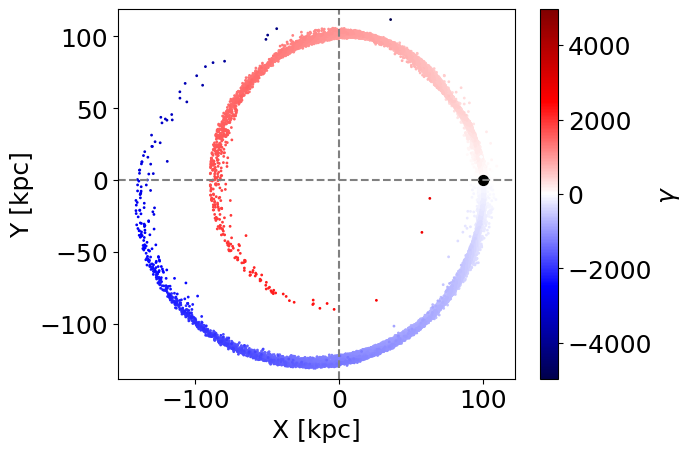

In [5]:
plt.scatter(xv_stream[:, 0], xv_stream[:, 1], c=xhi_stream, cmap='seismic', 
            vmin=min([min(xhi_stream), min(-xhi_stream)]), vmax=max([max(xhi_stream), max(-xhi_stream)]), s=1, alpha=1.)
plt.colorbar(label=r'$\gamma$')
plt.axvline(0, c='grey', linestyle='--')
plt.axhline(0, c='grey', linestyle='--')
plt.scatter(xv_sat[-1, 0], xv_sat[-1, 1], c='black', s=50)
plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')
plt.axis('equal');

### Get the Track

Usually when we work with stream, we are not interested in the complete stream but the radial position, width and density at given angle bins. We use the ordering to compute the angle bins and unwrap the stream. The angle is always centered on the final position of the satellite and follows an anti-clockwise ordering (contrairy to the ordering which is always positive for the leading tail and negative for the trailing).

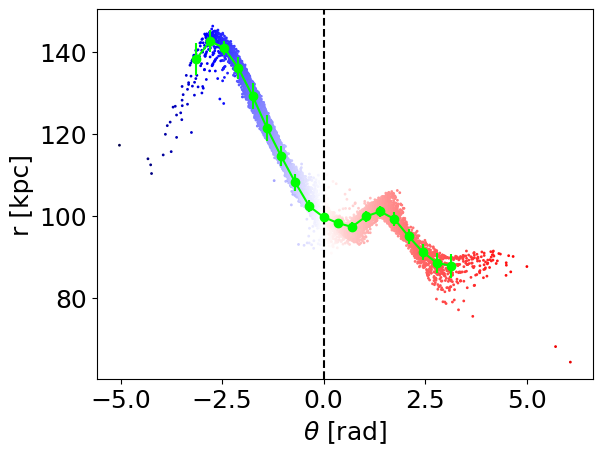

In [6]:
# Get ordered stream
x_stream, y_stream, theta_stream, r_stream, xhi_ordered = StreaMAX.get_stream_ordered(xv_stream[:, 0], xv_stream[:, 1], xhi_stream)

# Define widths and centers of the theta bins
widths       = jnp.deg2rad(20.)
theta_center = jnp.arange(-jnp.pi, jnp.pi, widths)

# Get 2D track vectorized
r_bin, sig_bin, count_bin = jax.vmap(StreaMAX.get_track_2D, in_axes=(None, None, 0, None))(theta_stream, r_stream, theta_center, widths)

plt.scatter(theta_stream, r_stream, c=xhi_ordered, cmap='seismic', 
            vmin=min([min(xhi_ordered), min(-xhi_ordered)]), vmax=max([max(xhi_ordered), max(-xhi_ordered)]), s=1, alpha=1.)
plt.errorbar(theta_center, r_bin, yerr=sig_bin, fmt='-o', c='lime')
plt.axvline(0, c='k', linestyle='--')
plt.xlabel(r'$\theta$ [rad]')
plt.ylabel('r [kpc]');

## Unroll

On a CPU, if you set unroll to be True, JAX will compile every iteration of the "for" loop. This makes the compiling a lot slower but the computation of the stream even faster. Therefore, we recommend setting unroll=True for longer jobs that will require generating multiple streams (i.e. optimization, bayesian inference). Note that this option is only viable if the n_steps is not too big since that parameter fixes how many iterations have to be compiled.

On a GPU, this is irrelevant.

In [7]:
unroll = True

a = tt.time()
t_sat, xv_sat, xv_stream, xhi_stream = jax.block_until_ready(StreaMAX.generate_stream(xv_f, 
                                                        type_host, params_host, 
                                                        type_sat, params_sat, 
                                                        time, alpha, n_steps,
                                                        n_particles, 
                                                        unroll))
b = tt.time()
print("Time taken to compile the pipeline and generate the stream with unroll=True: {:.3f} s".format((b-a)))

a = tt.time()
t_sat, xv_sat, xv_stream, xhi_stream = jax.block_until_ready(StreaMAX.generate_stream(xv_f, 
                                                                type_host, params_host, 
                                                                type_sat, params_sat, 
                                                                time, alpha, n_steps,
                                                                n_particles, 
                                                                unroll))
b = tt.time()
print("Time taken to generate the stream with unroll=True: {:.3f} ms".format((b-a)*1000))

Time taken to compile the pipeline and generate the stream with unroll=True: 0.037 s
Time taken to generate the stream with unroll=True: 22.619 ms


# Time Scaling

Let's see how computation time scales as a function of number of particles compared to $\texttt{Gala}$

In [8]:
import astropy.units as u
import numpy as np
import gala.potential as gp
import gala.dynamics as gd
import gala.integrate as gi
from gala.dynamics import mockstream as ms
from gala.units import galactic

pot = gp.NFWPotential(m=10**params_host['logM']*u.Msun, r_s=params_host['Rs']*u.kpc, units=galactic)
H = gp.Hamiltonian(pot)

prog_w0 = gd.PhaseSpacePosition(pos=[xv_f[0].item(), xv_f[1].item(), xv_f[2].item()] * u.kpc,
                                vel=[xv_f[3].item(), xv_f[4].item(), xv_f[5].item()] * u.kpc/u.Gyr)

df = ms.FardalStreamDF(gala_modified=True)
prog_mass =  10**params_sat['logM'] * u.Msun

gen = ms.MockStreamGenerator(df, H)

In [9]:
StreaMAX_time, Gala_time = [], []
n_particles_list = [1000, 5000, 10_000, 50_000, 100_000]
for n_particles in n_particles_list:
    # Compiling
    t_sat, xv_sat, xv_stream, xhi_stream = StreaMAX.generate_stream(xv_f, 
                                                            type_host, params_host, 
                                                            type_sat, params_sat, 
                                                            time, alpha, n_steps,
                                                            n_particles, 
                                                            unroll)

    StreaMAX_average, Gala_average = 0, 0
    for _ in range(100):
        a = tt.time()
        t_sat, xv_sat, xv_stream, xhi_stream = jax.block_until_ready(StreaMAX.generate_stream(xv_f, 
                                                                        type_host, params_host, 
                                                                        type_sat, params_sat, 
                                                                        time, alpha, n_steps,
                                                                        n_particles, 
                                                                        unroll))
        b = tt.time()
        StreaMAX_average += (b-a)*1000

        a = tt.time()
        stream, prog = gen.run(prog_w0, prog_mass, dt=-time/(n_steps) * u.Gyr, n_steps=n_steps, n_particles=n_particles/200, Integrator='leapfrog')
        b = tt.time()
        Gala_average += (b-a)*1000

    StreaMAX_time.append(StreaMAX_average/100)
    Gala_time.append(Gala_average/100)

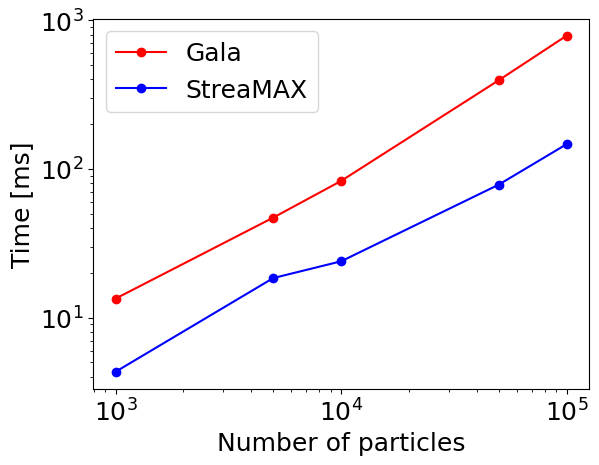

In [10]:
plt.plot(n_particles_list, Gala_time, '-o', color='red', label='Gala')
plt.plot(n_particles_list, StreaMAX_time, '-o', color='blue', label='StreaMAX')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of particles')
plt.ylabel('Time [ms]')
plt.legend(loc='best')